# Hourly Time Series Forecasting using Facebook's Prophet

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

1. Import useful libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

2. import the data thanks to the following link : ```s3://full-stack-bigdata-datasets/Machine Learning Supervisé/time_series/PJME_hourly.csv``` make sure to use the arguments ```index_col=[0], parse_dates=[0]``` and remove all dates previous to january the first 2008

In [ ]:
!pip install fsspec
!pip install s3fs

  Using cached s3fs-2021.10.1-py3-none-any.whl (26 kB)
Processing /home/jovyan/.cache/pip/wheels/89/67/d6/725476664f3da37fcebda5b1299af2b50702f98efa92591ae3/aiobotocore-1.4.2-py3-none-any.whl
  Using cached fsspec-2021.10.1-py3-none-any.whl (125 kB)
  Using cached wrapt-1.13.2-cp38-cp38-manylinux2010_x86_64.whl (84 kB)
  Using cached aioitertools-0.8.0-py3-none-any.whl (21 kB)
  Using cached botocore-1.20.106-py2.py3-none-any.whl (7.7 MB)
  Using cached aiohttp-3.7.4.post0-cp38-cp38-manylinux2014_x86_64.whl (1.5 MB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached yarl-1.7.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (308 kB)
  Using cached multidict-5.2.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (187 kB)
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.8.3
    Uninstall

In [ ]:
pjme = pd.read_csv('s3://full-stack-bigdata-datasets/Machine Learning Supervisé/time_series/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

start_date = '01-Jan-2008'
pjme = pjme.loc[pjme.index >= start_date, :]
pjme = pjme[~pjme.index.duplicated()] # Remove duplicate indices
pjme.head()

,PJME_MW
Datetime,
2008-01-01 00:00:00,30998.0
2008-12-31 01:00:00,28937.0
2008-12-31 02:00:00,27714.0
2008-12-31 03:00:00,27120.0
2008-12-31 04:00:00,26995.0


3. Plot the time series

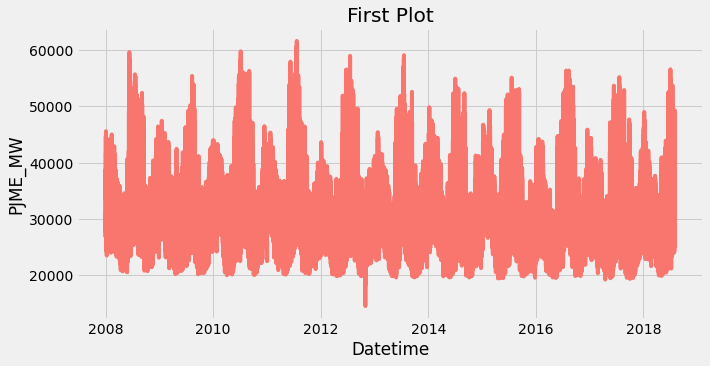

# EDA

4. Create this collection of new variables :
* ```date``` equal to the index
* ```hour``` equal to the hour of the day
* ```dayofweek```
* ```quarter```
* ```month```
* ```year```
* ```dayofyear```
* ```dayofmonth```
* ```weekofyear```

Create an object X containing the above variables and y containing the time series

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-5-19401c871ddc>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


5. Create an object features_and_target containing both and display the first few lines

In [ ]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2008-01-01 00:00:00,0,1,1,1,2008,1,1,1,30998.0
2008-12-31 01:00:00,1,2,4,12,2008,366,31,1,28937.0
2008-12-31 02:00:00,2,2,4,12,2008,366,31,1,27714.0
2008-12-31 03:00:00,3,2,4,12,2008,366,31,1,27120.0
2008-12-31 04:00:00,4,2,4,12,2008,366,31,1,26995.0


## Plotting the Features to see trends

6. Plot the time series against hour, dayofweek, year, weekofyear


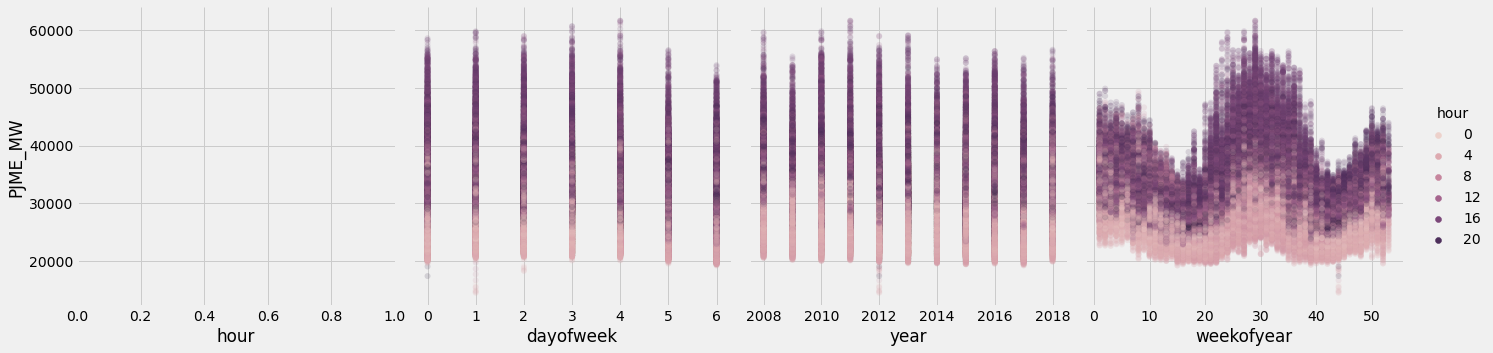

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
#plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
#plt.show()

# Train/Test Split
7. Cut off the data after 2015 to use as our validation set. We will train on earlier data.

8. plot the series with different colors for the train and test set to visualize the separation.

<AxesSubplot:xlabel='Datetime', ylabel='PJME_MW'>

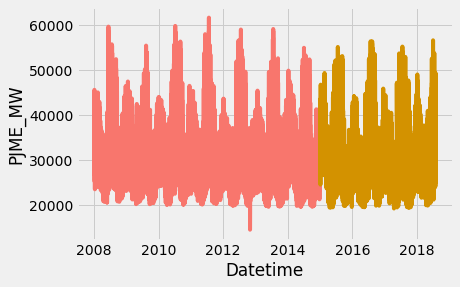

# Simple Prophet Model
9. In pjme_train rename the Datetime variable "ds" and PJME_MW "y" to fit into the Prophet framework

,ds,y
0,2008-01-01 00:00:00,30998.0
1,2008-12-31 01:00:00,28937.0
2,2008-12-31 02:00:00,27714.0
3,2008-12-31 03:00:00,27120.0
4,2008-12-31 04:00:00,26995.0


10. Create an instance of the Prophet model and fit it on the train data.

11. Make predictions with your trained default prophet model on the test set

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,30836.801761,25159.904101,34297.838925,30836.801761,30836.801761,-1050.691809,-1050.691809,-1050.691809,-4351.674436,...,1236.743486,1236.743486,1236.743486,2064.239141,2064.239141,2064.239141,0.0,0.0,0.0,29786.109952
1,2015-01-01 02:00:00,30836.678784,24275.995168,32439.218783,30836.678784,30836.678784,-2525.630244,-2525.630244,-2525.630244,-5821.078505,...,1228.611171,1228.611171,1228.611171,2066.837091,2066.837091,2066.837091,0.0,0.0,0.0,28311.048540
2,2015-01-01 03:00:00,30836.555807,23047.962280,31940.673670,30836.555807,30836.555807,-3381.426926,-3381.426926,-3381.426926,-6670.033961,...,1219.146287,1219.146287,1219.146287,2069.460748,2069.460748,2069.460748,0.0,0.0,0.0,27455.128881
3,2015-01-01 04:00:00,30836.432831,22701.382183,31620.645423,30836.432831,30836.432831,-3507.026082,-3507.026082,-3507.026082,-6787.594054,...,1208.457855,1208.457855,1208.457855,2072.110118,2072.110118,2072.110118,0.0,0.0,0.0,27329.406749
4,2015-01-01 05:00:00,30836.309854,23658.903308,32157.936295,30836.309854,30836.309854,-2816.315326,-2816.315326,-2816.315326,-6087.767286,...,1196.666759,1196.666759,1196.666759,2074.785201,2074.785201,2074.785201,0.0,0.0,0.0,28019.994528


13. Plot the trend, the yearly seasonnality, the weekly seasonnality, and the daily seasonnality.

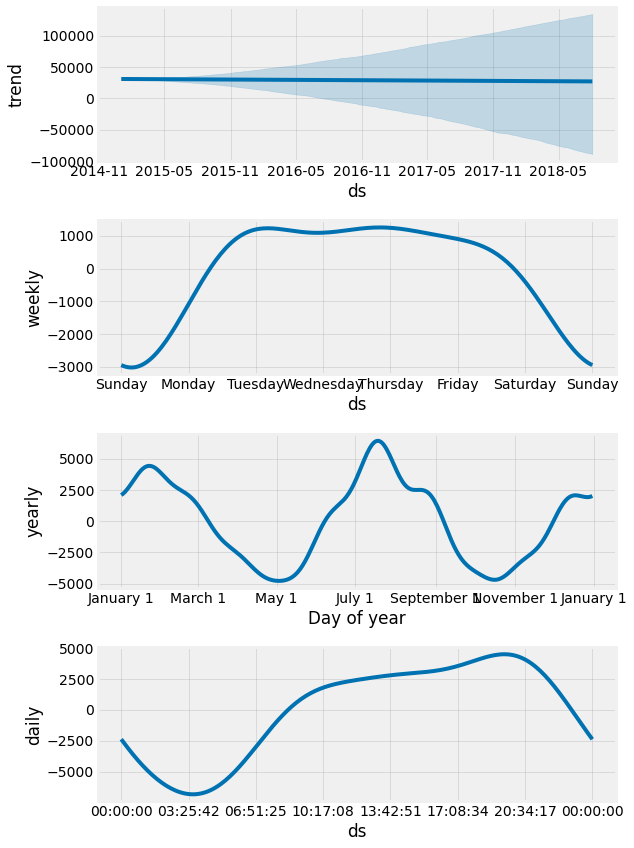

# Compare Forecast to Actuals

14. Plot the forcasts against the actual values in the test set.

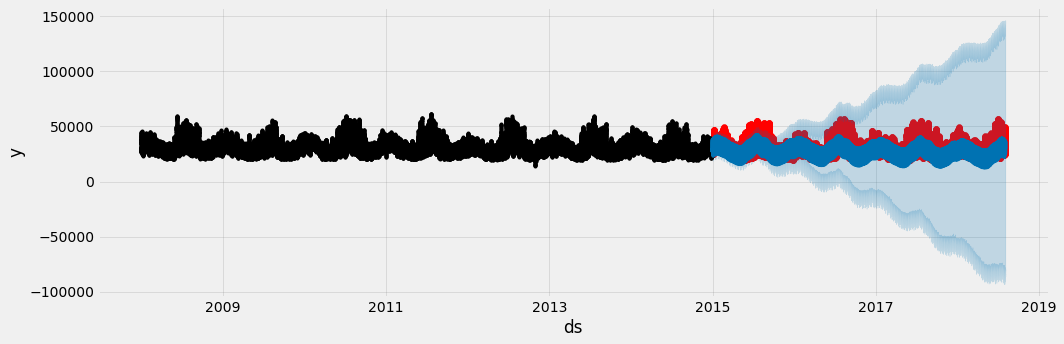

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Look at first month of predictions

15. Compare in a graph predictions for the first month against reality.

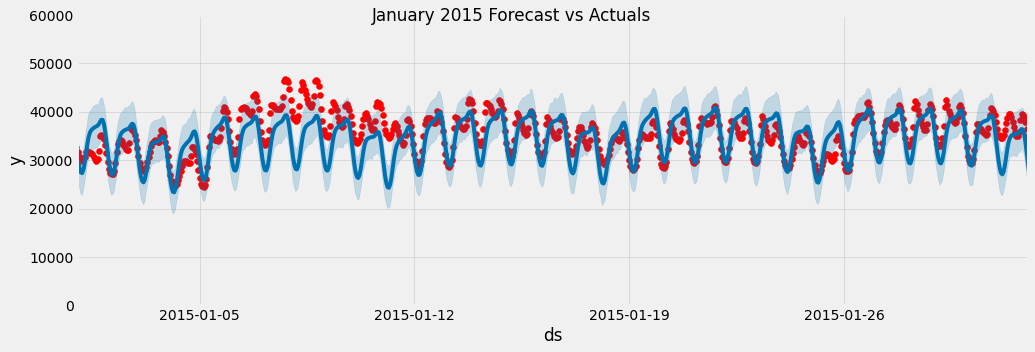

In [ ]:
# Plot the forecast with the actuals
from datetime import datetime
datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-01-2015', "%m-%d-%Y"),
              upper=datetime.strptime('02-01-2015', "%m-%d-%Y"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# Single Week of Predictions

16. plot the first week of data against the model's predictions

In [ ]:
from datetime import datetime

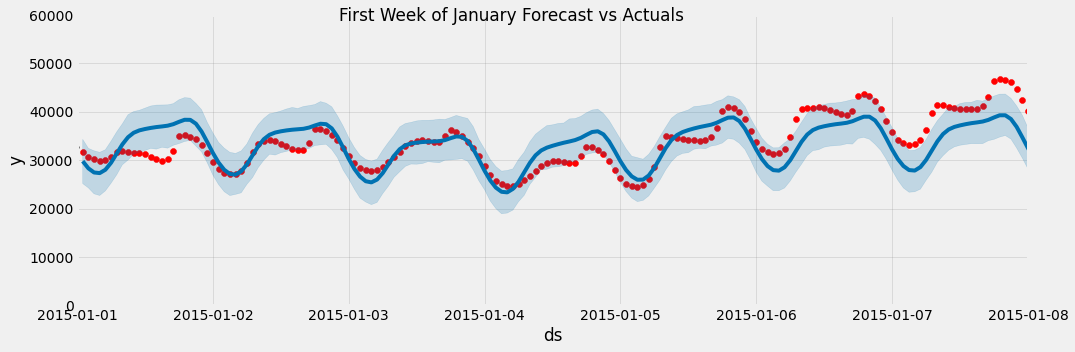

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-01-2015', "%m-%d-%Y"), upper=datetime.strptime('01-08-2015', "%m-%d-%Y"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

17. Calculate the MSE, the MAE and the MAPE (mean obsolute percentage error) for this model over the test dataset
$$MAPE = \frac{1}{n}\sum_{t=1}^{n}|\frac{Y_t - \hat{Y_t}}{Y_t}|$$

The MSE on the test set is : 
 49101928.0545092


The MAE on the test set is : 
 5473.142758559129


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MAPE on the test set is : 
 16.989611897094083


# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

18. Create a test_holidays object containing the us federal holidays for the considered test period and an object train_holidays for the considered train period.

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

19. Create a DataFrame contaning all holidays over the observed period with a ds column with the dates and a holiday column with the holidays and convert ds column to datetime format.

In [ ]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2008-01-01 00:00:00,USFederalHoliday
1,2009-01-01 00:00:00,USFederalHoliday
2,2008-12-25 01:00:00,USFederalHoliday
3,2008-12-25 02:00:00,USFederalHoliday
4,2008-12-25 03:00:00,USFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

20. Create an instance of the Prophet model with ```holidays = holiday_df``` the DataFrame we have just created, and train that model on the training set.

In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

## Predict With Holidays

21. Make predictions for the test set with the holiday model

In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = model_with_holidays.predict(df=pjme_test_prophet)

## Plot Holiday Effect

22. Plot the different components of the holiday model

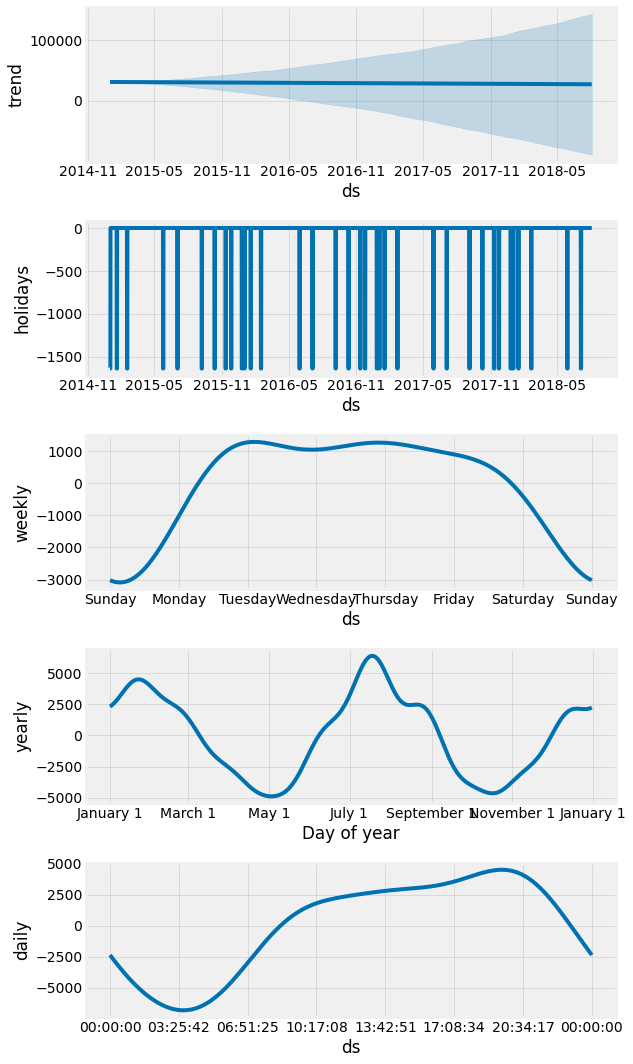

In [ ]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
23. Calculate the MSE, MAE and MAPE for the holiday model on the test set.

In [ ]:
mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 48925457.06198457


In [ ]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 5467.207105603384


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MAPE on the test set is : 
 16.98699887089391


# Compare Models Just for Holiday Dates
24. Lets plot Forecast model with and without holidays for 4th of July. It should look like the model with holidays is more accurate for this holiday.

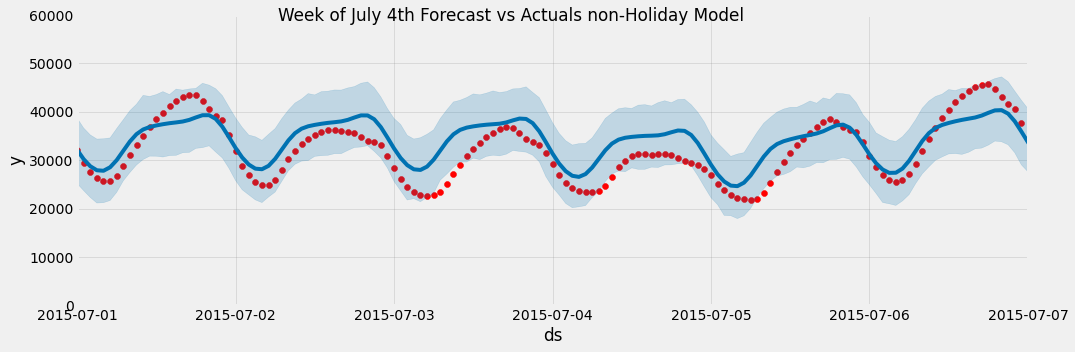

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('07-01-2015', "%m-%d-%Y"), upper=datetime.strptime('07-7-2015', "%m-%d-%Y"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

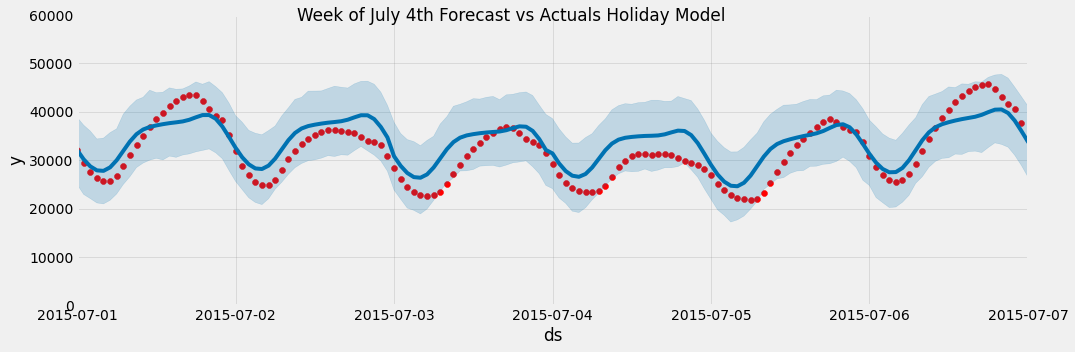

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=datetime.strptime('07-01-2015', "%m-%d-%Y"), upper=datetime.strptime('07-7-2015', "%m-%d-%Y"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

## Compare Error for just 4th of July
24. Compare MAE for 4th of july over the test set for the holiday model and non holiday model

In [ ]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [ ]:
mae = mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])
print("The MAE on the test set for the non-holiday model is : \n {}".format(mae))

The MAE on the test set for the non-holiday model is : 
 2035.6870997058752


In [ ]:
mae = mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

print("The MAE on the test set for the holiday model is : \n {}".format(mae))

The MAE on the test set for the holiday model is : 
 2026.8573475201672


# Error of all Holidays
25. Now compare the mae for all holidays, do you notice anything unexpected ?

In [ ]:
holiday_list = holiday_df['ds'].tolist()

In [ ]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [ ]:
mae = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
print("The MAE on the test set fot the non holiday model is : \n {}".format(mae))

The MAE on the test set fot the non holiday model is : 
 5490.125503612309


In [ ]:
mae = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])
print("The MAE on the test set for the holiday model is : \n {}".format(mae))

The MAE on the test set for the holiday model is : 
 5620.784265992639


# Plot Error of Each Forecast
26. Plot the forecast against the target variable for each model on the test set, what do you notice? Are there any observable phenomenon that the model is struggling to predict ?

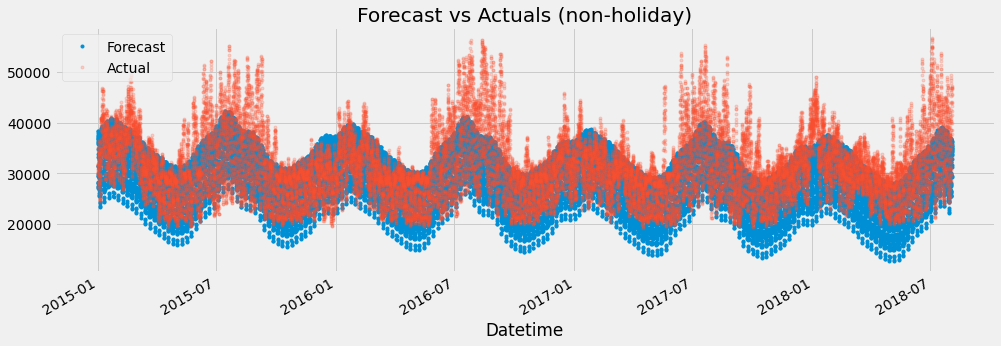

In [ ]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals (non-holiday)')
plt.show()

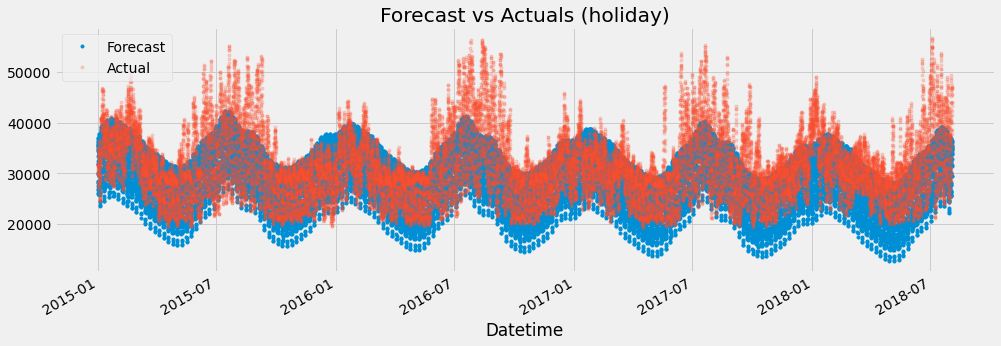

In [ ]:
ax = pjme_test_fcst_with_hols.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals (holiday)')
plt.show()